In [1]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# read in expr_preprocessed.h5ad
expr = sc.read_h5ad('expr_preprocessed.h5ad')
expanding_barcodes = pd.read_csv("barcodes_expanding_vs_contracting.csv", index_col=0)
barcodes_w_sc_and_tcr = set(expanding_barcodes.index) & set(expr.obs.index)

In [3]:
# Filter barcodes to only include those with shared data
expanding_barcodes = expanding_barcodes.loc[list(barcodes_w_sc_and_tcr)]

# Label sc data to clarify which have tcr data
expr.obs["has_tcr_data"] = False
expr.obs.loc[list(barcodes_w_sc_and_tcr), "has_tcr_data"] = True

## Check whether the expanding early clones are more likely to highly express the 'highly variable' genes

In [78]:
high_var_genes = expr.var.query("highly_variable")
expr_df = pd.DataFrame(expr.X, index=expr.obs.index, columns=expr.var.index)

def make_violin_plots_for_timepoint(timepoint: str = "early"):

   barcodes_that_expand = expanding_barcodes.query(f"{timepoint} == True").index
   barcodes_that_contract = expanding_barcodes.query(f"{timepoint} == False").index

   high_var_non_trb = high_var_genes.sort_values("dispersions_norm", ascending=False).query("trb == False").head(5).index.tolist()
   high_var_trb = high_var_genes.sort_values("dispersions_norm", ascending=False).query("trb == True").head(5).index.tolist() 
   random_5_genes = expr.var.sample(5).index.tolist()
      
   for title, genes_to_plot in zip(["High var non-TRB genes", "High var TRB genes", "Randomly selected genes"], [high_var_non_trb, high_var_trb, random_5_genes]):
      high_var_trb_expr = expr_df.loc[list(barcodes_that_expand)+list(barcodes_that_contract), genes_to_plot]

      high_var_trb_expr = high_var_trb_expr.reset_index().melt(id_vars="index").rename({"index": "barcode", "variable": "gene", "value": "expr_level"}, axis=1)

      high_var_trb_expr = high_var_trb_expr.set_index("barcode")
      high_var_trb_expr.loc[barcodes_that_expand, "kinetics"] = "expand"
      high_var_trb_expr.loc[barcodes_that_contract, "kinetics"] = "contract"

      plt.figure(figsize=(10, 5))
      sns.violinplot(data=high_var_trb_expr, x="gene", y="expr_level", hue="kinetics", split=True, linewidth=0.25)
      sns.stripplot(data=high_var_trb_expr, x="gene", y="expr_level", hue="kinetics", zorder=1, s=1.5, alpha=0.25)

      # fix legend so it only shows each state once
      handles, labels = plt.gca().get_legend_handles_labels()
      by_label = dict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys(), title=f"{timepoint} kinetics", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

      plt.title(f"Expression of high variance genes in {timepoint} expanding and contracting clones, {title}")

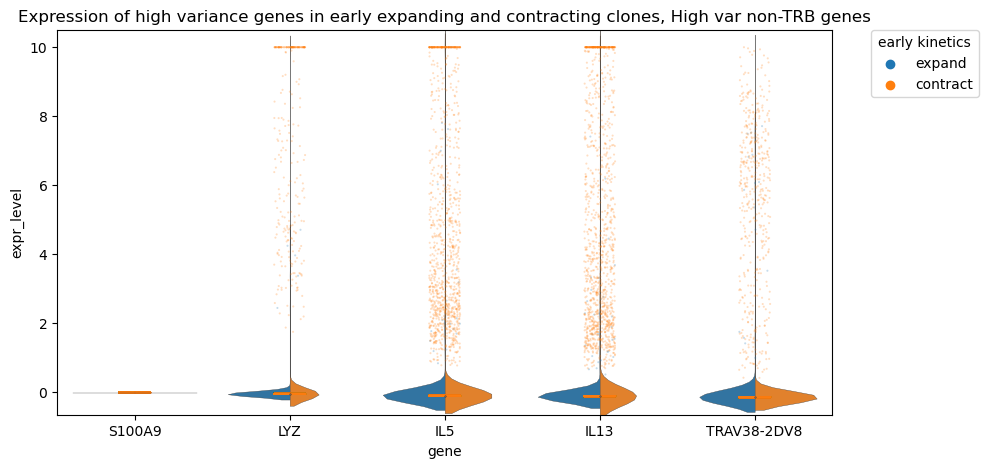

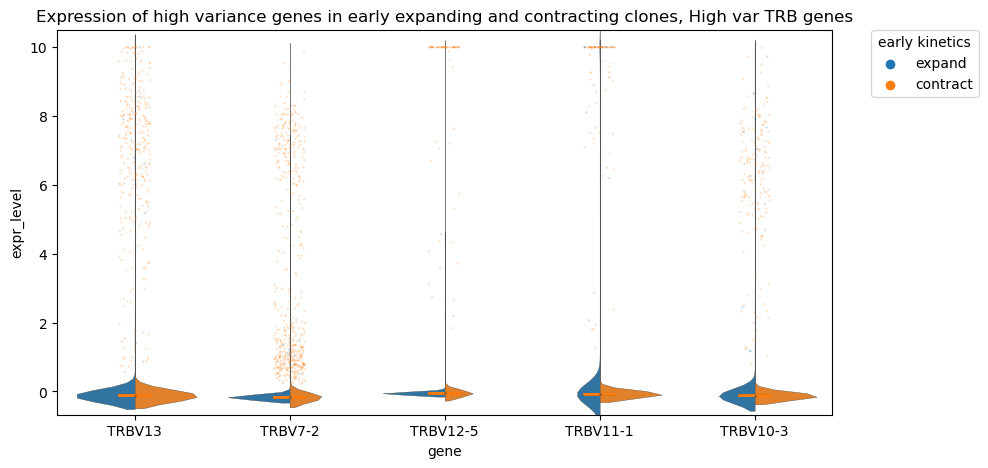

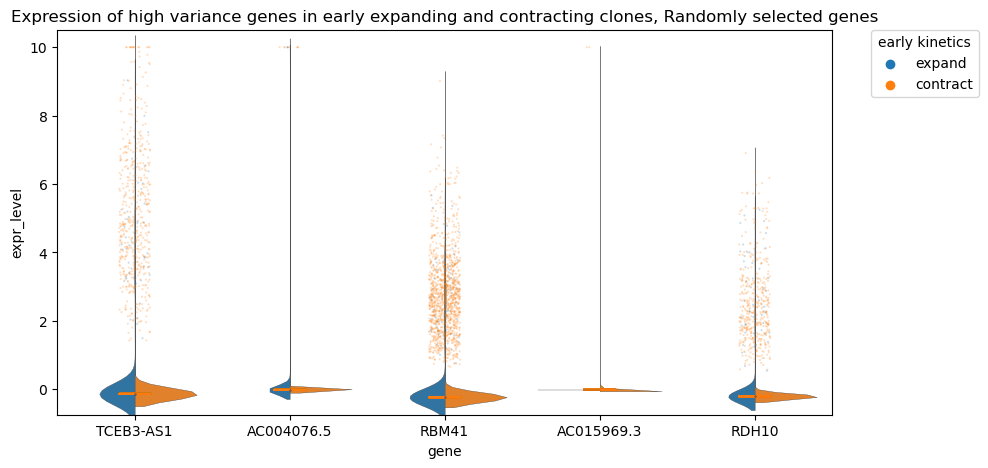

In [79]:
make_violin_plots_for_timepoint("early")

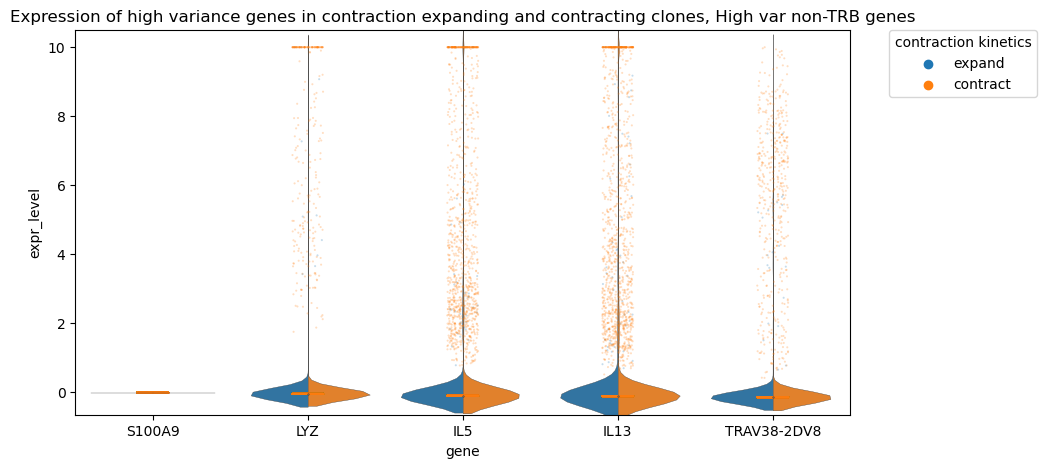

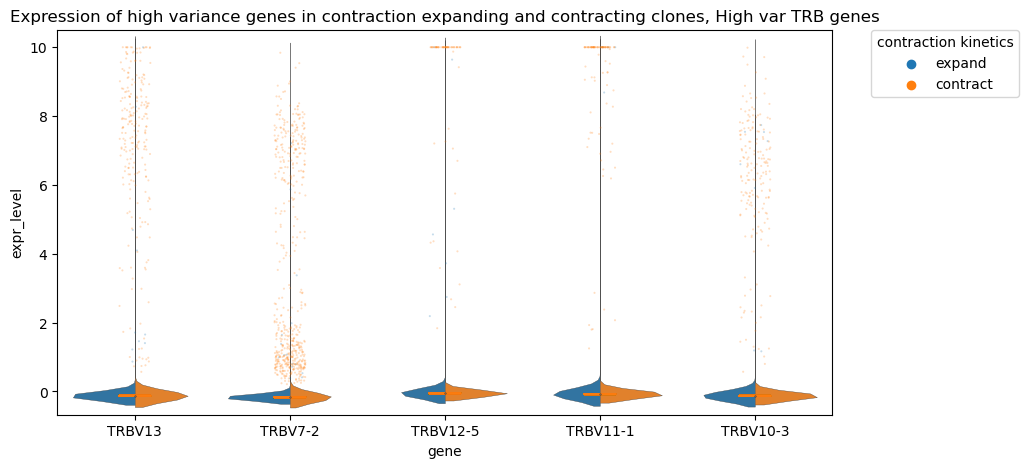

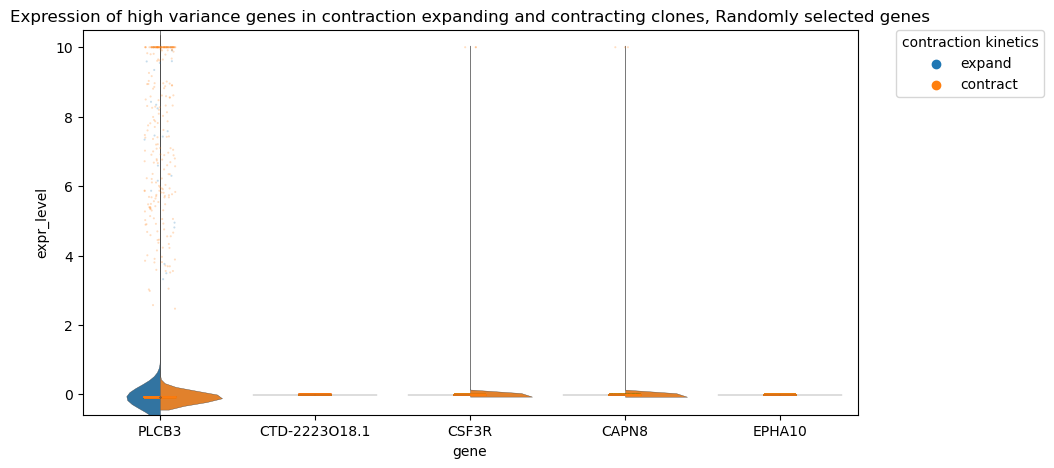

In [80]:
make_violin_plots_for_timepoint("contraction")

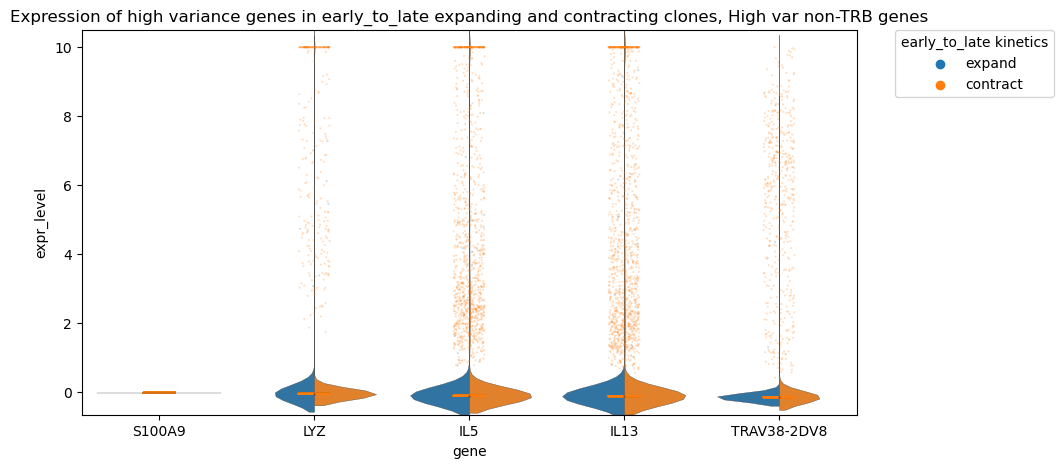

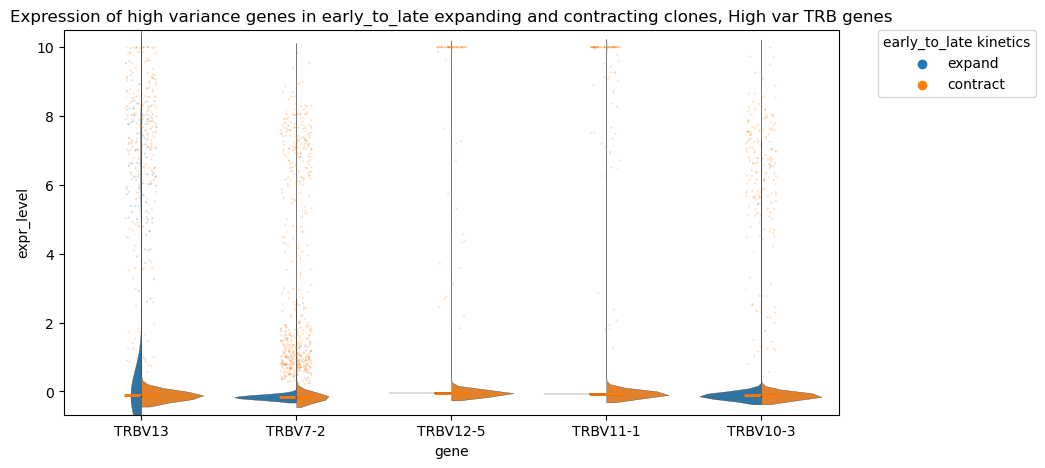

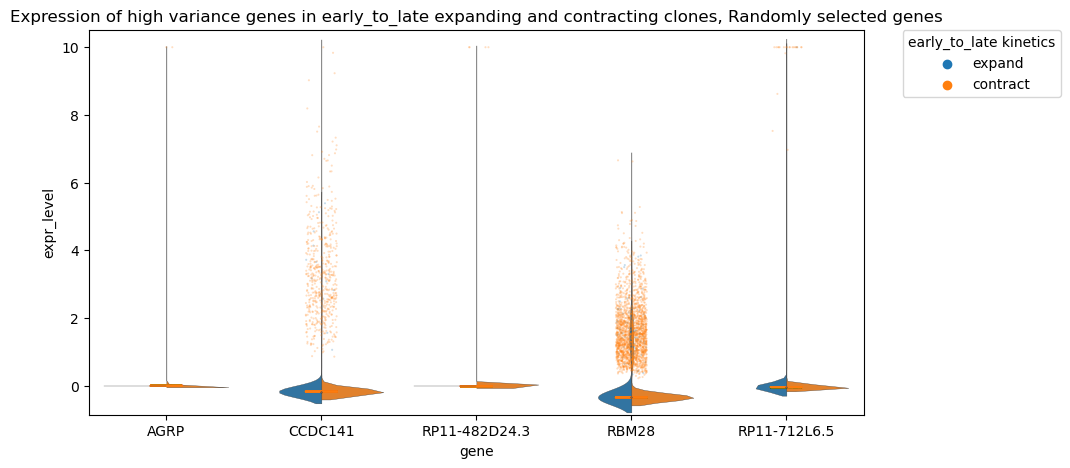

In [57]:
make_violin_plots_for_timepoint("early_to_late")

#### As a sanity check, look more closely into the expression of S100A9, which is a gene that is highly expressed but has very little expression

In [75]:
expr.var.loc["S100A9"]

mt                           False
n_cells_by_counts               77
mean_counts               0.019689
pct_dropout_by_counts     99.87614
total_counts                1224.0
n_cells                         77
highly_variable               True
means                     0.013921
dispersions               4.757143
dispersions_norm         14.140092
trb                          False
mean                       0.00145
std                       0.058021
Name: S100A9, dtype: object

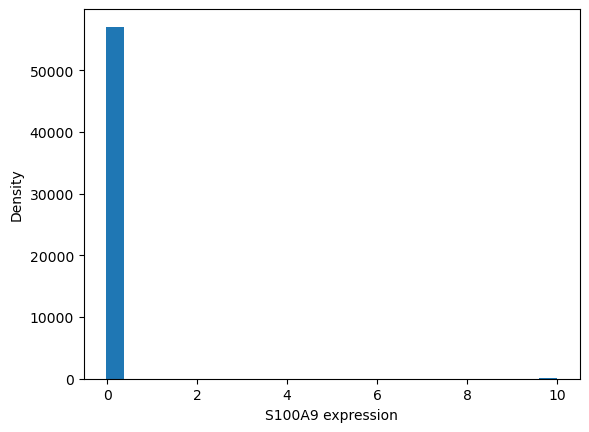

In [81]:
plt.hist(expr_df["S100A9"], bins=25)
plt.xlabel("S100A9 expression")
plt.ylabel("Density")
plt.show()

# it seems like it was only expressed in a very small population of cells (77) and ust happens to have pretty high dispersion because of the few cells that had high expression